# Class-Conditional EDM (Elucidated Diffusion Models) for CRCHistoPhenotypes

Implementation based on Karras et al. 2022: "Elucidating the Design Space of Diffusion-Based Generative Models"

**Key differences from DDPM:**
- Continuous sigma-based noise schedule (log-normal sampling)
- Preconditioning (c_skip, c_out, c_in, c_noise) for stable training
- Much faster sampling (35-50 steps vs 1000)
- Predicts denoised image instead of noise

**Dataset**: CRCHistoPhenotypes (32x32 RGB, 4 classes)

## Setup

In [1]:
import os
import re
import glob
import math
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from diffusers import UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import numpy as np

# Device
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

C:\Users\user\anaconda3\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Configuration
DATASET_PATH = "CRCHisto_Synthetic/data/biomedical/biomedical"
CHECKPOINT_DIR = "CRCHisto_Synthetic/diffusion_edm_model_checkpoints"
SAMPLE_DIR = "CRCHisto_Synthetic/diffusion_edm_model_samples"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 2e-4  # EDM typically uses slightly higher LR
NUM_CLASSES = 4
CLASS_EMB_SIZE = 4
IMAGE_SIZE = 32

# EDM-specific parameters (from Karras et al. 2022)
SIGMA_MIN = 0.002
SIGMA_MAX = 80.0
SIGMA_DATA = 0.5  # Estimated std of the data
P_MEAN = -1.2     # Mean of log-normal distribution for training
P_STD = 1.2       # Std of log-normal distribution for training
RHO = 7.0         # Schedule curvature for sampling

# Class names
CLASS_NAMES = ['epithelial', 'fibroblast', 'inflammatory', 'others']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

print(f"EDM Config: sigma_min={SIGMA_MIN}, sigma_max={SIGMA_MAX}, sigma_data={SIGMA_DATA}")

EDM Config: sigma_min=0.002, sigma_max=80.0, sigma_data=0.5


## Dataset

In [3]:
class CRCDataset(Dataset):
    """CRCHistoPhenotypes Dataset"""

    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = Path(root_dir) / split
        self.samples = []

        for class_name in CLASS_NAMES:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                    for img_path in class_dir.glob(ext):
                        self.samples.append((img_path, CLASS_TO_IDX[class_name]))

        self.transform = transform or transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # [-1, 1]
        ])

        print(f"Loaded {len(self.samples)} images from {split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label


# Load dataset
train_dataset = CRCDataset(DATASET_PATH, split='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

# View samples
x, y = next(iter(train_loader))
print(f'Batch shape: {x.shape}')
print(f'Data range: [{x.min():.2f}, {x.max():.2f}]')

Loaded 20444 images from train
Batch shape: torch.Size([128, 3, 32, 32])
Data range: [-1.00, 1.00]


## EDM Preconditioning

EDM uses preconditioning to ensure stable training across all noise levels:

- $c_{skip}(\sigma) = \frac{\sigma_{data}^2}{\sigma^2 + \sigma_{data}^2}$
- $c_{out}(\sigma) = \frac{\sigma \cdot \sigma_{data}}{\sqrt{\sigma^2 + \sigma_{data}^2}}$  
- $c_{in}(\sigma) = \frac{1}{\sqrt{\sigma^2 + \sigma_{data}^2}}$
- $c_{noise}(\sigma) = \frac{1}{4} \ln(\sigma)$

The network output $D_\theta$ is combined as:
$$D_\theta(x; \sigma) = c_{skip}(\sigma) \cdot x + c_{out}(\sigma) \cdot F_\theta(c_{in}(\sigma) \cdot x; c_{noise}(\sigma))$$

In [4]:
class EDMPrecond(nn.Module):
    """
    EDM Preconditioning wrapper for UNet.

    Implements the preconditioning from Karras et al. 2022:
    D(x; sigma) = c_skip * x + c_out * F(c_in * x; c_noise)
    """

    def __init__(
        self,
        unet: nn.Module,
        sigma_data: float = 0.5,
    ):
        super().__init__()
        self.unet = unet
        self.sigma_data = sigma_data

    def forward(self, x, sigma, class_labels):
        """
        Args:
            x: Noisy images [B, C, H, W]
            sigma: Noise levels [B] or [B, 1, 1, 1]
            class_labels: Class indices [B]

        Returns:
            Denoised images [B, C, H, W]
        """
        # Ensure sigma has right shape
        if sigma.dim() == 1:
            sigma = sigma.view(-1, 1, 1, 1)

        # Compute preconditioning weights
        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_noise = 0.25 * sigma.flatten().log()

        # Scale input
        scaled_x = c_in * x

        # Forward through UNet
        # Note: UNet expects timestep, we use c_noise which encodes sigma
        # We'll map c_noise to a pseudo-timestep for the UNet
        F_x = self.unet(scaled_x, c_noise, class_labels)

        # Apply skip connection and output scaling
        D_x = c_skip * x + c_out * F_x

        return D_x

In [5]:
class ClassConditionedUnetEDM(nn.Module):
    """
    Class-conditioned UNet for EDM.

    Key difference from DDPM version:
    - Accepts continuous c_noise (log-sigma) instead of discrete timesteps
    - The UNet internally converts c_noise to embeddings
    """

    def __init__(self, num_classes=4, class_emb_size=4):
        super().__init__()

        # Class embedding
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # UNet
        self.model = UNet2DModel(
            sample_size=32,                      # 32x32 images
            in_channels=3 + class_emb_size,      # RGB + class embedding
            out_channels=3,                      # RGB output
            layers_per_block=2,
            block_out_channels=(64, 128, 128, 256),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
        )

        self.image_size = 32
        self.class_emb_size = class_emb_size

    def forward(self, x, c_noise, class_labels):
        """
        Args:
            x: Scaled input images [B, C, H, W]
            c_noise: Noise conditioning (0.25 * ln(sigma)) [B]
            class_labels: Class indices [B]
        """
        bs = x.shape[0]

        # Get class embedding and expand spatially
        class_cond = self.class_emb(class_labels)
        class_cond = class_cond.view(bs, -1, 1, 1).expand(bs, -1, self.image_size, self.image_size)

        # Concatenate
        net_input = torch.cat([x, class_cond], dim=1)

        # For diffusers UNet, we need to convert c_noise to a timestep-like value
        # Map c_noise to [0, 1000] range for compatibility
        # c_noise = 0.25 * ln(sigma), so sigma = exp(4 * c_noise)
        # We'll use c_noise directly as the timestep embedding input
        # The UNet will treat it as a continuous "timestep"
        timestep = c_noise  # Already in reasonable range for sinusoidal embedding

        return self.model(net_input, timestep).sample

In [6]:
# Create model with EDM preconditioning
unet = ClassConditionedUnetEDM(num_classes=NUM_CLASSES, class_emb_size=CLASS_EMB_SIZE)
model = EDMPrecond(unet, sigma_data=SIGMA_DATA).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,} ({num_params/1e6:.1f}M)")

# Test forward pass
with torch.no_grad():
    test_x = torch.randn(2, 3, 32, 32, device=device)
    test_sigma = torch.tensor([0.1, 1.0], device=device)
    test_labels = torch.tensor([0, 1], device=device)
    out = model(test_x, test_sigma, test_labels)
    print(f"Input: {test_x.shape} -> Output: {out.shape}")

Model parameters: 18,538,643 (18.5M)
Input: torch.Size([2, 3, 32, 32]) -> Output: torch.Size([2, 3, 32, 32])


## EDM Training

Training objective: Predict the denoised image

1. Sample $\sigma$ from log-normal: $\ln(\sigma) \sim \mathcal{N}(P_{mean}, P_{std}^2)$
2. Add noise: $x_{noisy} = x + \sigma \cdot \epsilon$
3. Predict denoised: $\hat{x} = D_\theta(x_{noisy}; \sigma)$
4. Loss: weighted MSE between $\hat{x}$ and $x$

In [7]:
def sample_sigma(batch_size, p_mean=P_MEAN, p_std=P_STD, device='cuda'):
    """
    Sample sigma from log-normal distribution.
    ln(sigma) ~ N(p_mean, p_std^2)
    """
    ln_sigma = torch.randn(batch_size, device=device) * p_std + p_mean
    sigma = ln_sigma.exp()
    return sigma


def edm_loss(model, x, class_labels, sigma_data=SIGMA_DATA):
    """
    EDM training loss.

    Args:
        model: EDMPrecond wrapped model
        x: Clean images [B, C, H, W]
        class_labels: Class indices [B]

    Returns:
        Weighted MSE loss
    """
    batch_size = x.shape[0]

    # Sample sigma from log-normal
    sigma = sample_sigma(batch_size, device=x.device)

    # Sample noise and create noisy images
    noise = torch.randn_like(x)
    x_noisy = x + sigma.view(-1, 1, 1, 1) * noise

    # Predict denoised image
    x_pred = model(x_noisy, sigma, class_labels)

    # Compute loss weight: lambda(sigma) = (sigma^2 + sigma_data^2) / (sigma * sigma_data)^2
    weight = (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2
    weight = weight.view(-1, 1, 1, 1)

    # Weighted MSE loss
    loss = weight * (x_pred - x) ** 2

    return loss.mean()


# Test loss computation
with torch.no_grad():
    test_x = torch.randn(4, 3, 32, 32, device=device)
    test_labels = torch.tensor([0, 1, 2, 3], device=device)
    test_loss = edm_loss(model, test_x, test_labels)
    print(f"Test loss: {test_loss.item():.4f}")

Test loss: 1.8413


## EDM Sampling (Euler Method)

EDM uses deterministic ODE sampling:

1. Create sigma schedule from $\sigma_{max}$ to $\sigma_{min}$
2. For each step: $x_{t+1} = x_t + (\sigma_{t+1} - \sigma_t) \cdot \frac{x_t - D_\theta(x_t; \sigma_t)}{\sigma_t}$

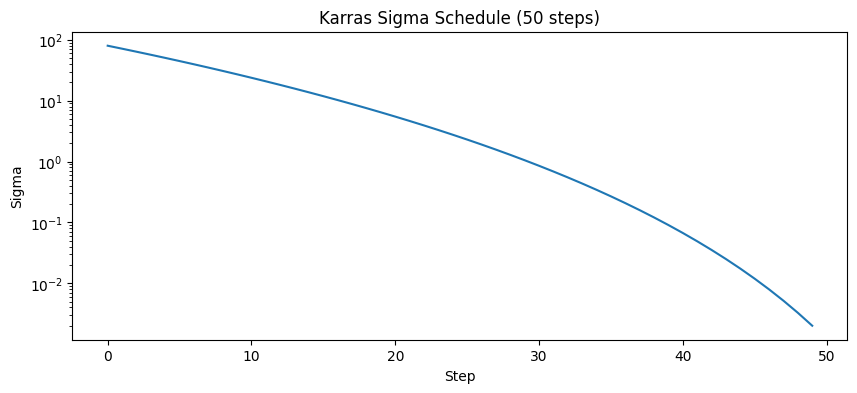

In [8]:
def get_sigmas_karras(n_steps, sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX, rho=RHO, device='cuda'):
    """
    Get sigma schedule using Karras et al. schedule.

    sigma_i = (sigma_max^(1/rho) + i/(n-1) * (sigma_min^(1/rho) - sigma_max^(1/rho)))^rho
    """
    ramp = torch.linspace(0, 1, n_steps, device=device)
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho

    # Append 0 for the final step
    sigmas = torch.cat([sigmas, torch.zeros(1, device=device)])

    return sigmas


@torch.no_grad()
def edm_sample(
    model,
    num_samples=16,
    class_labels=None,
    num_steps=50,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
):
    """
    Generate samples using EDM Euler sampler.

    Args:
        model: EDMPrecond wrapped model
        num_samples: Number of samples to generate
        class_labels: Optional class labels [num_samples]
        num_steps: Number of sampling steps (default: 50)

    Returns:
        Generated images [num_samples, 3, 32, 32]
    """
    model.eval()

    # Create class labels if not provided
    if class_labels is None:
        class_labels = torch.arange(NUM_CLASSES, device=device).repeat_interleave(num_samples // NUM_CLASSES)
        num_samples = len(class_labels)

    # Get sigma schedule
    sigmas = get_sigmas_karras(num_steps, sigma_min, sigma_max, device=device)

    # Start from noise at sigma_max
    x = torch.randn(num_samples, 3, IMAGE_SIZE, IMAGE_SIZE, device=device) * sigma_max

    # Euler sampling
    for i in tqdm(range(len(sigmas) - 1), desc="Sampling"):
        sigma = sigmas[i]
        sigma_next = sigmas[i + 1]

        # Get denoised prediction
        denoised = model(x, sigma.expand(num_samples), class_labels)

        # Euler step
        d = (x - denoised) / sigma
        x = x + d * (sigma_next - sigma)

    # Clamp and denormalize
    x = x.clamp(-1, 1)
    x = (x + 1) / 2

    return x


# Visualize sigma schedule
sigmas = get_sigmas_karras(50, device='cpu')
plt.figure(figsize=(10, 4))
plt.plot(sigmas[:-1].numpy())
plt.xlabel('Step')
plt.ylabel('Sigma')
plt.title('Karras Sigma Schedule (50 steps)')
plt.yscale('log')
plt.show()

## 2nd Order Heun Sampler (Better Quality)

In [9]:
@torch.no_grad()
def edm_sample_heun(
    model,
    num_samples=16,
    class_labels=None,
    num_steps=50,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    s_churn=0.0,  # Stochasticity (0 = deterministic)
    s_noise=1.0,
):
    """
    Generate samples using EDM 2nd order Heun sampler.
    Better quality than Euler, same number of function evaluations.
    """
    model.eval()

    if class_labels is None:
        class_labels = torch.arange(NUM_CLASSES, device=device).repeat_interleave(num_samples // NUM_CLASSES)
        num_samples = len(class_labels)

    sigmas = get_sigmas_karras(num_steps, sigma_min, sigma_max, device=device)
    x = torch.randn(num_samples, 3, IMAGE_SIZE, IMAGE_SIZE, device=device) * sigma_max

    for i in tqdm(range(len(sigmas) - 1), desc="Sampling (Heun)"):
        sigma = sigmas[i]
        sigma_next = sigmas[i + 1]

        # Optional: Add noise for stochastic sampling
        if s_churn > 0:
            gamma = min(s_churn / num_steps, 2 ** 0.5 - 1)
            sigma_hat = sigma * (1 + gamma)
            x = x + (sigma_hat ** 2 - sigma ** 2).sqrt() * s_noise * torch.randn_like(x)
            sigma = sigma_hat

        # First order step (Euler)
        denoised = model(x, sigma.expand(num_samples), class_labels)
        d = (x - denoised) / sigma
        x_next = x + d * (sigma_next - sigma)

        # Second order correction (Heun)
        if sigma_next > 0:
            denoised_next = model(x_next, sigma_next.expand(num_samples), class_labels)
            d_next = (x_next - denoised_next) / sigma_next
            d_avg = (d + d_next) / 2
            x = x + d_avg * (sigma_next - sigma)
        else:
            x = x_next

    x = x.clamp(-1, 1)
    x = (x + 1) / 2

    return x

## Training Loop with Checkpoint Resume

In [10]:
def find_latest_checkpoint(checkpoint_dir):
    """Find the latest checkpoint based on epoch number"""
    checkpoint_pattern = os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pt')
    checkpoints = glob.glob(checkpoint_pattern)

    if not checkpoints:
        return None, 0

    latest_checkpoint = None
    latest_epoch = 0

    for ckpt in checkpoints:
        match = re.search(r'checkpoint_epoch_(\d+)\.pt', ckpt)
        if match:
            epoch = int(match.group(1))
            if epoch > latest_epoch:
                latest_epoch = epoch
                latest_checkpoint = ckpt

    return latest_checkpoint, latest_epoch

No checkpoint found. Starting training from scratch.


Epoch 1/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.2670]


Epoch 1 - Average Loss: 0.3517


Epoch 2/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.43it/s, loss=0.2199]


Epoch 2 - Average Loss: 0.2414


Epoch 3/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.47it/s, loss=0.2289]


Epoch 3 - Average Loss: 0.2256


Epoch 4/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:03<00:00,  2.51it/s, loss=0.2339]


Epoch 4 - Average Loss: 0.2179


Epoch 5/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.44it/s, loss=0.2141]


Epoch 5 - Average Loss: 0.2112


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.62it/s]


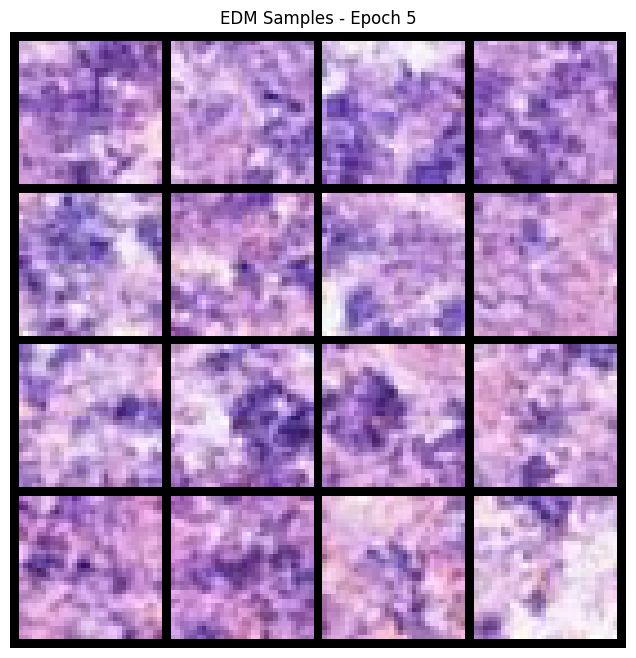

Epoch 6/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.2040]


Epoch 6 - Average Loss: 0.2069


Epoch 7/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:19<00:00,  1.99it/s, loss=0.1923]


Epoch 7 - Average Loss: 0.2024


Epoch 8/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.18it/s, loss=0.1976]


Epoch 8 - Average Loss: 0.1996


Epoch 9/100: 100%|██████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.48it/s, loss=0.1904]


Epoch 9 - Average Loss: 0.1974


Epoch 10/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.47it/s, loss=0.2087]


Epoch 10 - Average Loss: 0.1951
Saved checkpoint at epoch 10


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.12it/s]


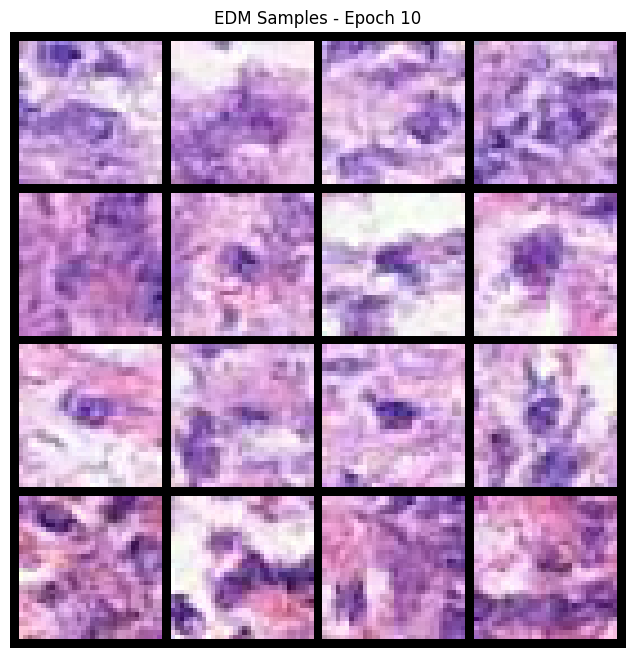

Epoch 11/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.47it/s, loss=0.2018]


Epoch 11 - Average Loss: 0.1931


Epoch 12/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:08<00:00,  2.34it/s, loss=0.2009]


Epoch 12 - Average Loss: 0.1923


Epoch 13/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.1878]


Epoch 13 - Average Loss: 0.1905


Epoch 14/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.1855]


Epoch 14 - Average Loss: 0.1893


Epoch 15/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.36it/s, loss=0.1867]


Epoch 15 - Average Loss: 0.1884


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.42it/s]


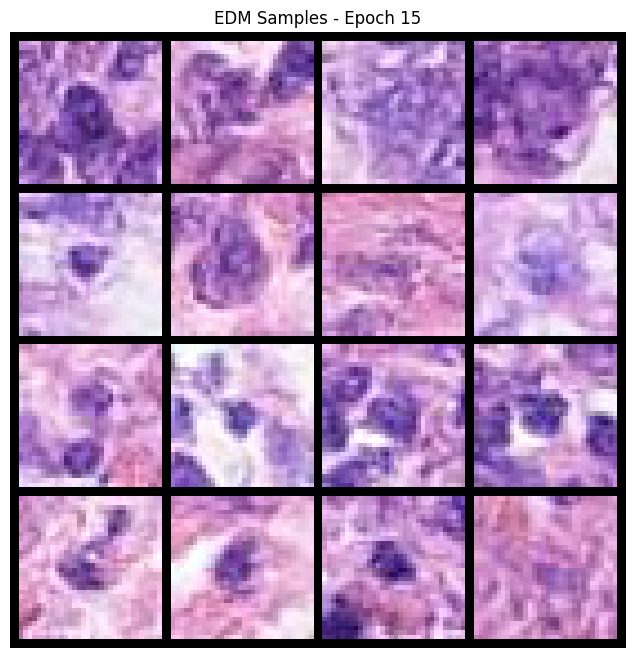

Epoch 16/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1854]


Epoch 16 - Average Loss: 0.1876


Epoch 17/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:08<00:00,  2.34it/s, loss=0.1880]


Epoch 17 - Average Loss: 0.1876


Epoch 18/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.1945]


Epoch 18 - Average Loss: 0.1857


Epoch 19/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1754]


Epoch 19 - Average Loss: 0.1856


Epoch 20/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.34it/s, loss=0.1821]


Epoch 20 - Average Loss: 0.1843
Saved checkpoint at epoch 20


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.41it/s]


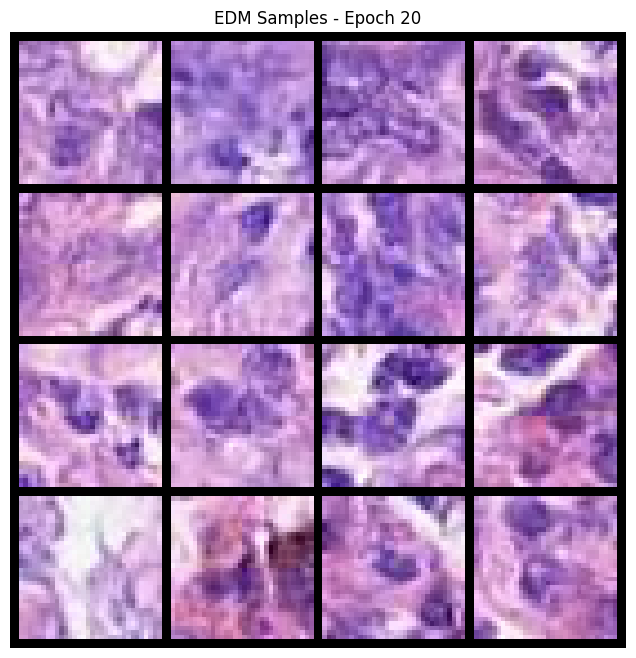

Epoch 21/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1759]


Epoch 21 - Average Loss: 0.1838


Epoch 22/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.37it/s, loss=0.1777]


Epoch 22 - Average Loss: 0.1844


Epoch 23/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.1766]


Epoch 23 - Average Loss: 0.1829


Epoch 24/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.1807]


Epoch 24 - Average Loss: 0.1824


Epoch 25/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:03<00:00,  2.51it/s, loss=0.1812]


Epoch 25 - Average Loss: 0.1816


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.71it/s]


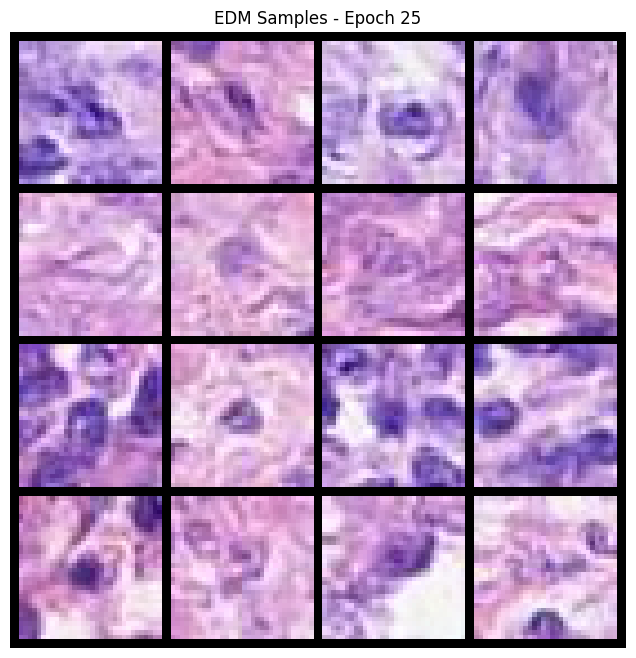

Epoch 26/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.37it/s, loss=0.1845]


Epoch 26 - Average Loss: 0.1816


Epoch 27/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1806]


Epoch 27 - Average Loss: 0.1810


Epoch 28/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:10<00:00,  2.26it/s, loss=0.1856]


Epoch 28 - Average Loss: 0.1814


Epoch 29/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s, loss=0.1744]


Epoch 29 - Average Loss: 0.1810


Epoch 30/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.1878]


Epoch 30 - Average Loss: 0.1795
Saved checkpoint at epoch 30


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.88it/s]


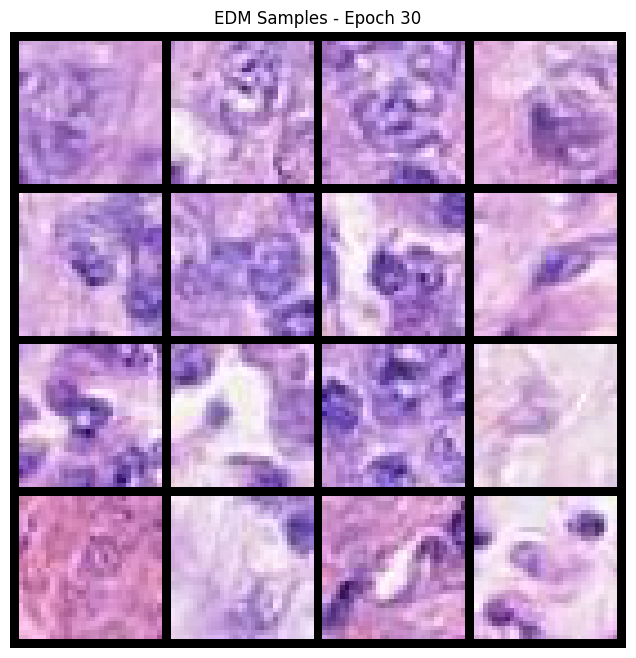

Epoch 31/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.44it/s, loss=0.1749]


Epoch 31 - Average Loss: 0.1791


Epoch 32/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.45it/s, loss=0.1839]


Epoch 32 - Average Loss: 0.1790


Epoch 33/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:08<00:00,  2.33it/s, loss=0.1755]


Epoch 33 - Average Loss: 0.1790


Epoch 34/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.38it/s, loss=0.1818]


Epoch 34 - Average Loss: 0.1788


Epoch 35/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.1850]


Epoch 35 - Average Loss: 0.1794


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.25it/s]


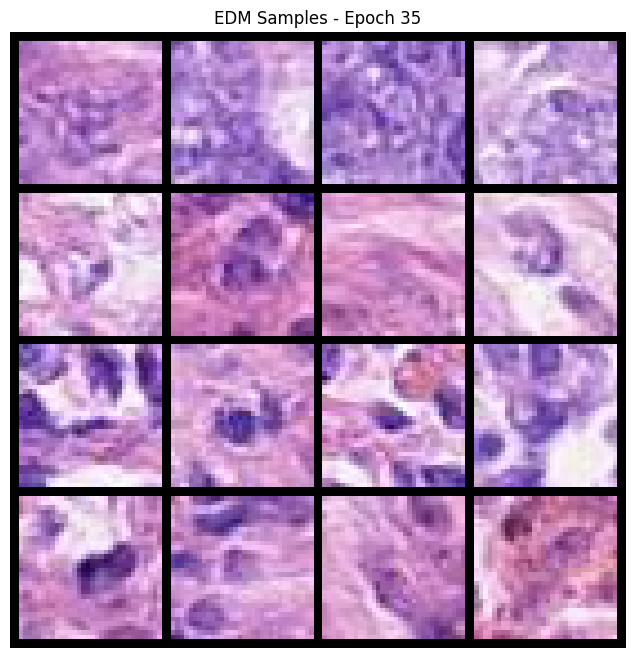

Epoch 36/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:08<00:00,  2.31it/s, loss=0.1749]


Epoch 36 - Average Loss: 0.1782


Epoch 37/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:09<00:00,  2.30it/s, loss=0.1778]


Epoch 37 - Average Loss: 0.1783


Epoch 38/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:15<00:00,  2.10it/s, loss=0.1855]


Epoch 38 - Average Loss: 0.1777


Epoch 39/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.1832]


Epoch 39 - Average Loss: 0.1782


Epoch 40/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1689]


Epoch 40 - Average Loss: 0.1783
Saved checkpoint at epoch 40


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.46it/s]


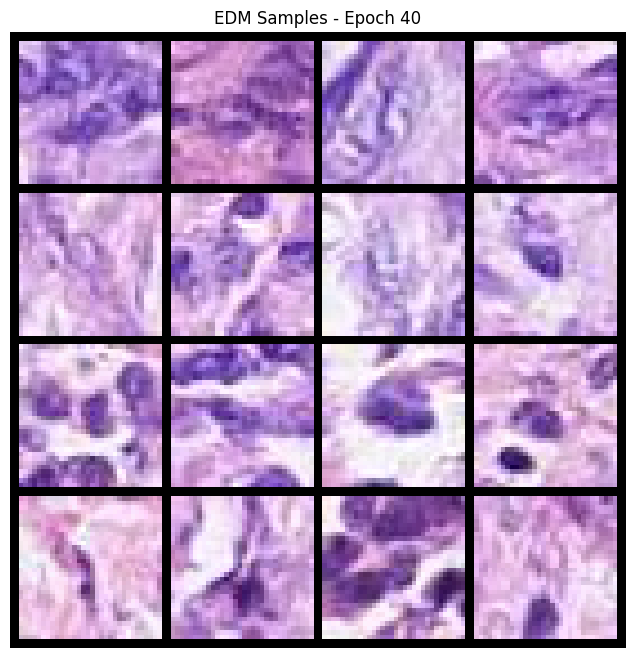

Epoch 41/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:16<00:00,  2.08it/s, loss=0.1781]


Epoch 41 - Average Loss: 0.1767


Epoch 42/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:22<00:00,  1.93it/s, loss=0.1824]


Epoch 42 - Average Loss: 0.1761


Epoch 43/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:15<00:00,  2.11it/s, loss=0.1639]


Epoch 43 - Average Loss: 0.1769


Epoch 44/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:14<00:00,  2.14it/s, loss=0.1724]


Epoch 44 - Average Loss: 0.1758


Epoch 45/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:11<00:00,  2.21it/s, loss=0.1699]


Epoch 45 - Average Loss: 0.1757


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.85it/s]


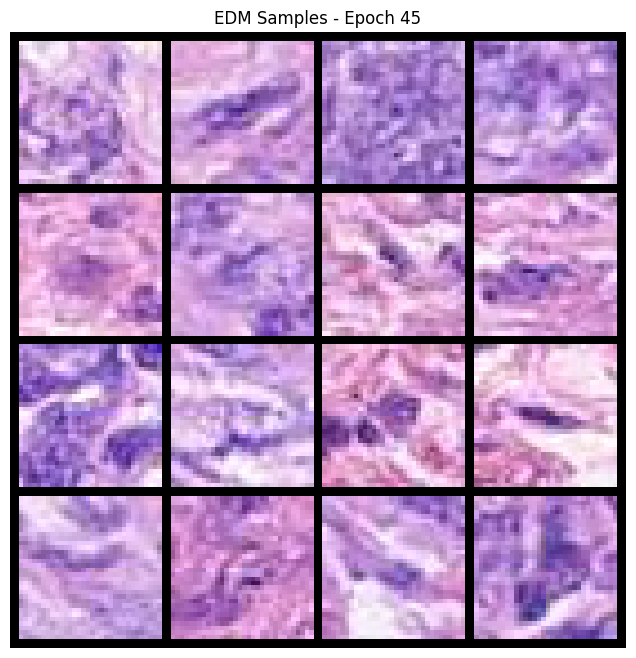

Epoch 46/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:13<00:00,  2.15it/s, loss=0.1697]


Epoch 46 - Average Loss: 0.1758


Epoch 47/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:15<00:00,  2.10it/s, loss=0.1834]


Epoch 47 - Average Loss: 0.1751


Epoch 48/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:14<00:00,  2.14it/s, loss=0.1709]


Epoch 48 - Average Loss: 0.1749


Epoch 49/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:13<00:00,  2.17it/s, loss=0.1842]


Epoch 49 - Average Loss: 0.1748


Epoch 50/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:14<00:00,  2.13it/s, loss=0.1819]


Epoch 50 - Average Loss: 0.1754
Saved checkpoint at epoch 50


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.94it/s]


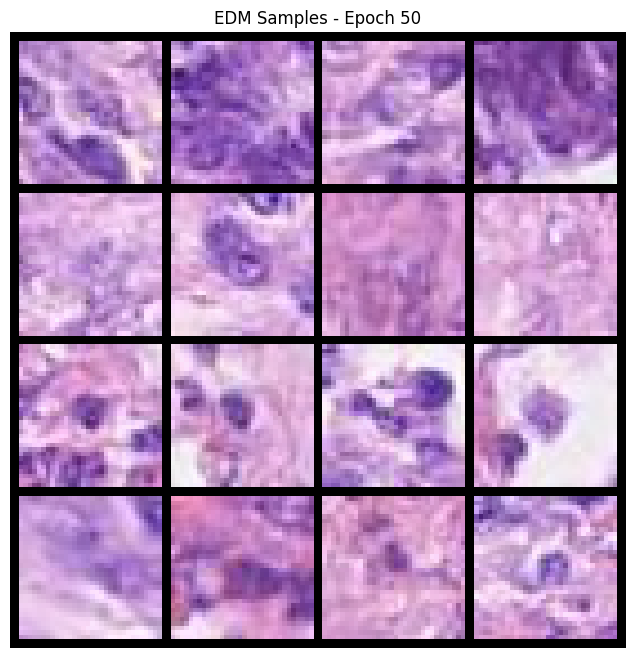

Epoch 51/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:16<00:00,  2.07it/s, loss=0.1729]


Epoch 51 - Average Loss: 0.1751


Epoch 52/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:24<00:00,  1.87it/s, loss=0.1813]


Epoch 52 - Average Loss: 0.1744


Epoch 53/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.21it/s, loss=0.1765]


Epoch 53 - Average Loss: 0.1745


Epoch 54/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.41it/s, loss=0.1732]


Epoch 54 - Average Loss: 0.1745


Epoch 55/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:20<00:00,  1.97it/s, loss=0.1813]


Epoch 55 - Average Loss: 0.1735


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.88it/s]


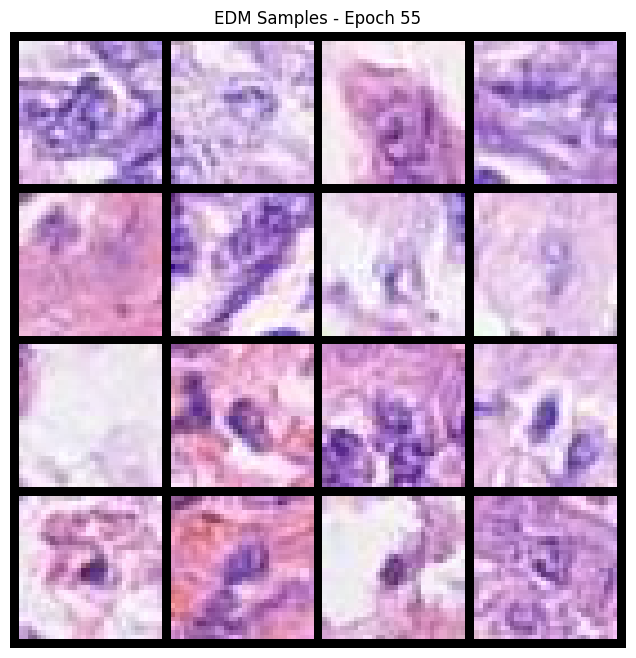

Epoch 56/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:15<00:00,  2.10it/s, loss=0.1733]


Epoch 56 - Average Loss: 0.1738


Epoch 58/100: 100%|█████████████████████████████████████████████████████| 159/159 [00:54<00:00,  2.91it/s, loss=0.1715]


Epoch 58 - Average Loss: 0.1729


Epoch 59/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:01<00:00,  2.58it/s, loss=0.1749]


Epoch 59 - Average Loss: 0.1728


Epoch 60/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:08<00:00,  2.31it/s, loss=0.1645]


Epoch 60 - Average Loss: 0.1727
Saved checkpoint at epoch 60


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.26it/s]


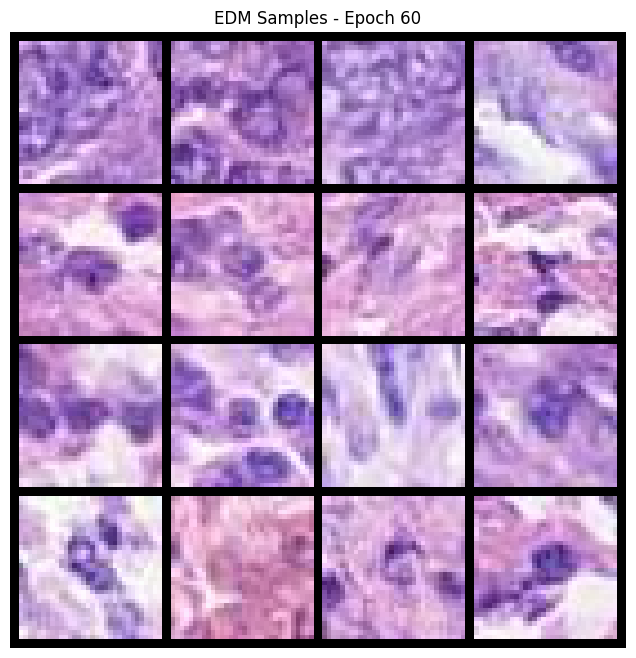

Epoch 61/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1742]


Epoch 61 - Average Loss: 0.1727


Epoch 62/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.19it/s, loss=0.1688]


Epoch 62 - Average Loss: 0.1722


Epoch 63/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1718]


Epoch 63 - Average Loss: 0.1722


Epoch 64/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.40it/s, loss=0.1671]


Epoch 64 - Average Loss: 0.1727


Epoch 65/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.46it/s, loss=0.1754]


Epoch 65 - Average Loss: 0.1714


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.08it/s]


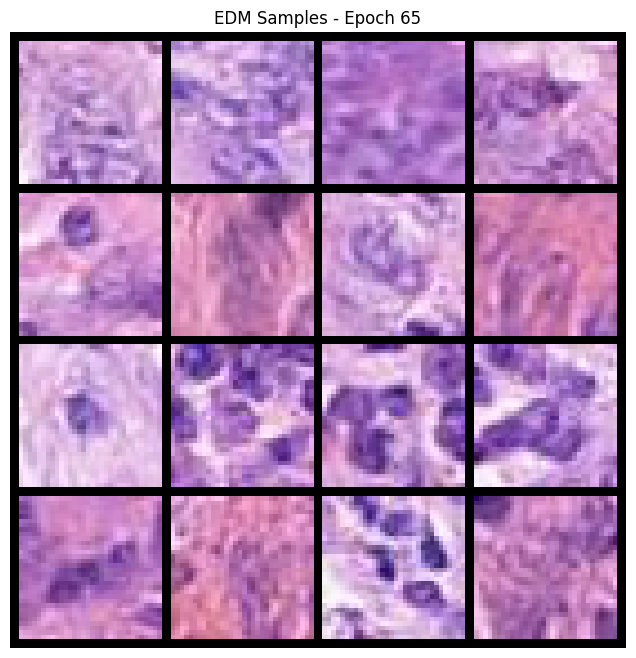

Epoch 66/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.44it/s, loss=0.1789]


Epoch 66 - Average Loss: 0.1715


Epoch 67/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.48it/s, loss=0.1724]


Epoch 67 - Average Loss: 0.1714


Epoch 68/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.44it/s, loss=0.1634]


Epoch 68 - Average Loss: 0.1723


Epoch 69/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.43it/s, loss=0.1779]


Epoch 69 - Average Loss: 0.1709


Epoch 70/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.41it/s, loss=0.1639]


Epoch 70 - Average Loss: 0.1712
Saved checkpoint at epoch 70


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.31it/s]


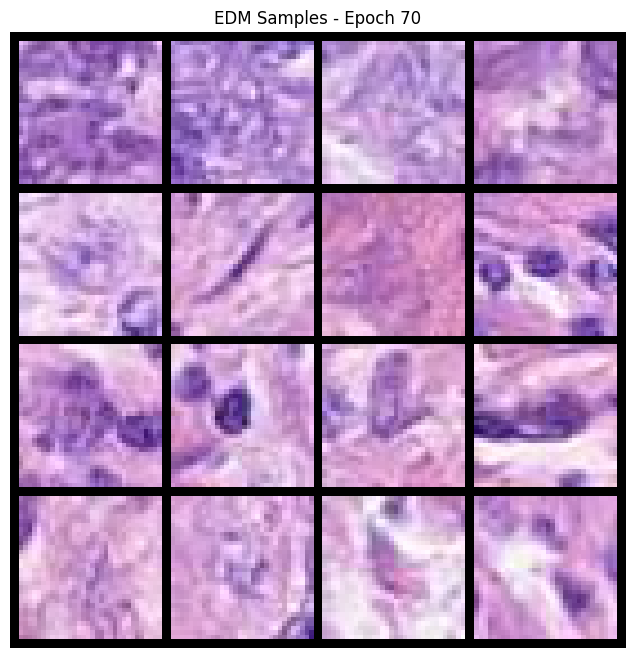

Epoch 71/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.48it/s, loss=0.1696]


Epoch 71 - Average Loss: 0.1711


Epoch 72/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.44it/s, loss=0.1786]


Epoch 72 - Average Loss: 0.1709


Epoch 73/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.47it/s, loss=0.1770]


Epoch 73 - Average Loss: 0.1702


Epoch 74/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.44it/s, loss=0.1728]


Epoch 74 - Average Loss: 0.1701


Epoch 75/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:13<00:00,  2.15it/s, loss=0.1663]


Epoch 75 - Average Loss: 0.1709


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.33it/s]


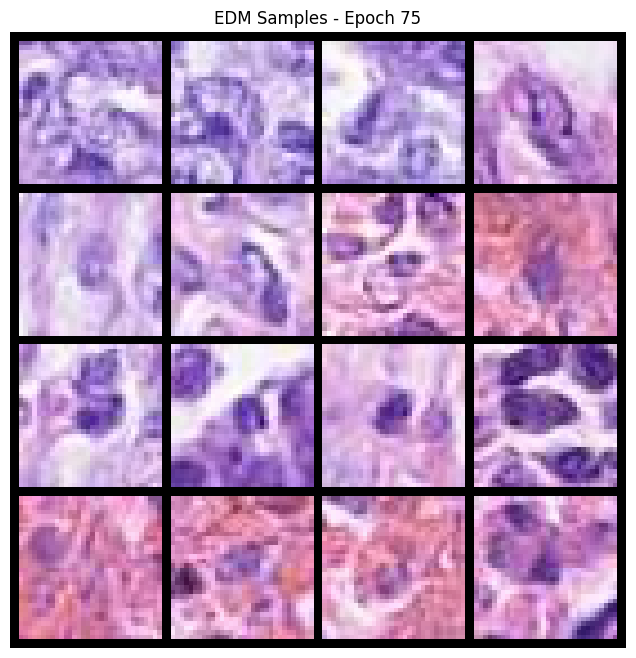

Epoch 76/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:15<00:00,  2.12it/s, loss=0.1657]


Epoch 76 - Average Loss: 0.1704


Epoch 77/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:14<00:00,  2.14it/s, loss=0.1791]


Epoch 77 - Average Loss: 0.1697


Epoch 78/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.19it/s, loss=0.1636]


Epoch 78 - Average Loss: 0.1693


Epoch 79/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.19it/s, loss=0.1794]


Epoch 79 - Average Loss: 0.1690


Epoch 80/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:09<00:00,  2.28it/s, loss=0.1741]


Epoch 80 - Average Loss: 0.1694
Saved checkpoint at epoch 80


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.82it/s]


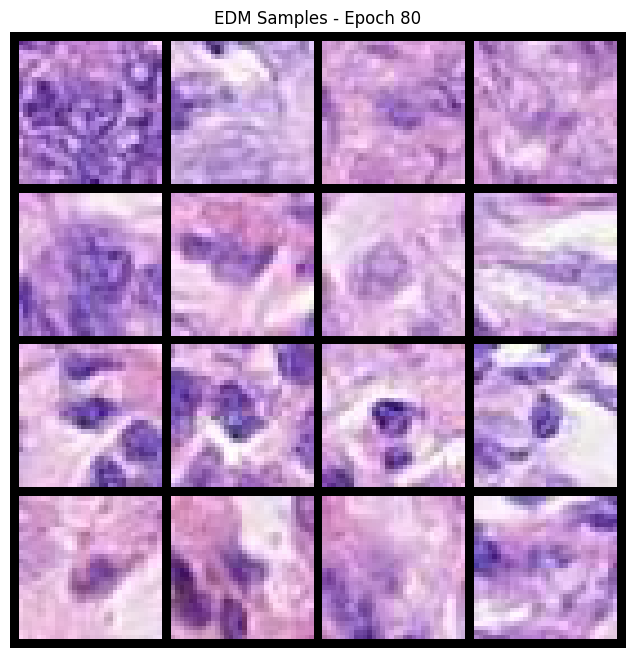

Epoch 81/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:13<00:00,  2.18it/s, loss=0.1801]


Epoch 81 - Average Loss: 0.1696


Epoch 82/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.19it/s, loss=0.1712]


Epoch 82 - Average Loss: 0.1695


Epoch 83/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:56<00:00,  1.37it/s, loss=0.1699]


Epoch 83 - Average Loss: 0.1691


Epoch 84/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:11<00:00,  2.22it/s, loss=0.1693]


Epoch 84 - Average Loss: 0.1691


Epoch 85/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:16<00:00,  2.08it/s, loss=0.1829]


Epoch 85 - Average Loss: 0.1693


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.96it/s]


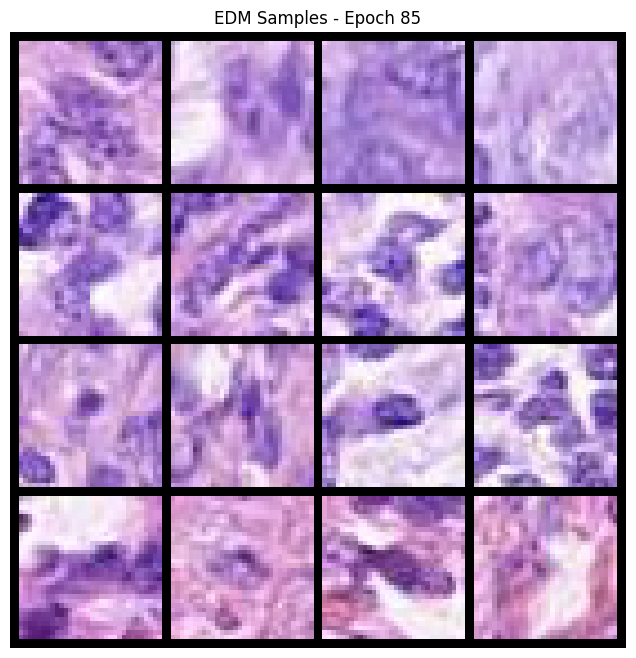

Epoch 86/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:16<00:00,  2.09it/s, loss=0.1608]


Epoch 86 - Average Loss: 0.1696


Epoch 87/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:13<00:00,  2.16it/s, loss=0.1704]


Epoch 87 - Average Loss: 0.1683


Epoch 88/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:13<00:00,  2.16it/s, loss=0.1627]


Epoch 88 - Average Loss: 0.1680


Epoch 89/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.19it/s, loss=0.1628]


Epoch 89 - Average Loss: 0.1681


Epoch 90/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:16<00:00,  2.09it/s, loss=0.1772]


Epoch 90 - Average Loss: 0.1683
Saved checkpoint at epoch 90


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.13it/s]


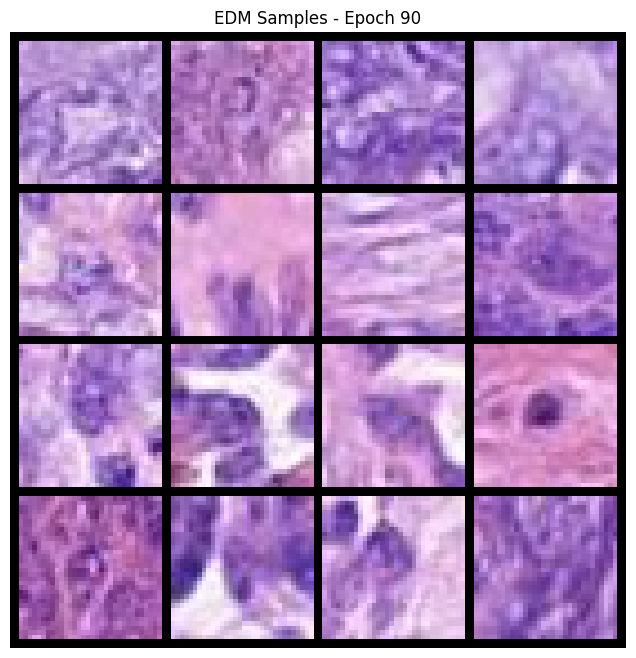

Epoch 91/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:16<00:00,  2.09it/s, loss=0.1716]


Epoch 91 - Average Loss: 0.1677


Epoch 92/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:14<00:00,  2.14it/s, loss=0.1699]


Epoch 92 - Average Loss: 0.1682


Epoch 93/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:15<00:00,  2.11it/s, loss=0.1654]


Epoch 93 - Average Loss: 0.1685


Epoch 94/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:12<00:00,  2.19it/s, loss=0.1727]


Epoch 94 - Average Loss: 0.1681


Epoch 95/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:08<00:00,  2.31it/s, loss=0.1607]


Epoch 95 - Average Loss: 0.1677


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.51it/s]


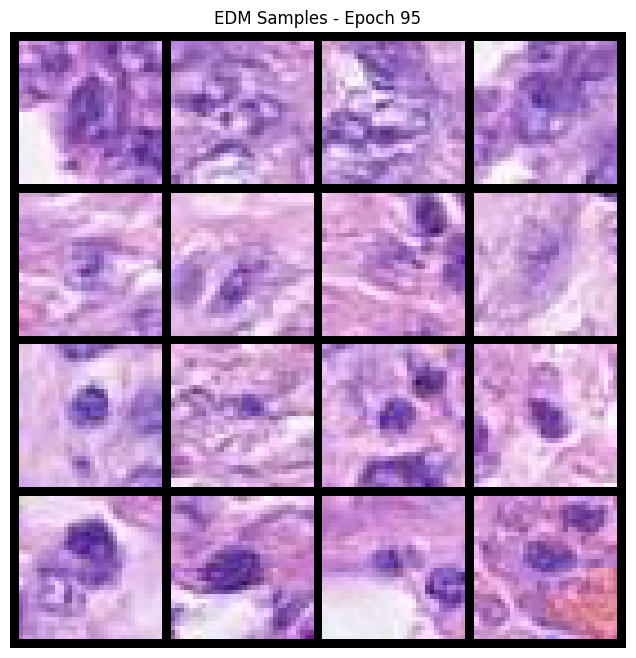

Epoch 96/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:07<00:00,  2.35it/s, loss=0.1643]


Epoch 96 - Average Loss: 0.1679


Epoch 97/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:04<00:00,  2.45it/s, loss=0.1593]


Epoch 97 - Average Loss: 0.1675


Epoch 98/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.43it/s, loss=0.1601]


Epoch 98 - Average Loss: 0.1682


Epoch 99/100: 100%|█████████████████████████████████████████████████████| 159/159 [01:06<00:00,  2.39it/s, loss=0.1670]


Epoch 99 - Average Loss: 0.1678


Epoch 100/100: 100%|████████████████████████████████████████████████████| 159/159 [01:05<00:00,  2.42it/s, loss=0.1662]


Epoch 100 - Average Loss: 0.1670
Saved checkpoint at epoch 100


Sampling: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.32it/s]


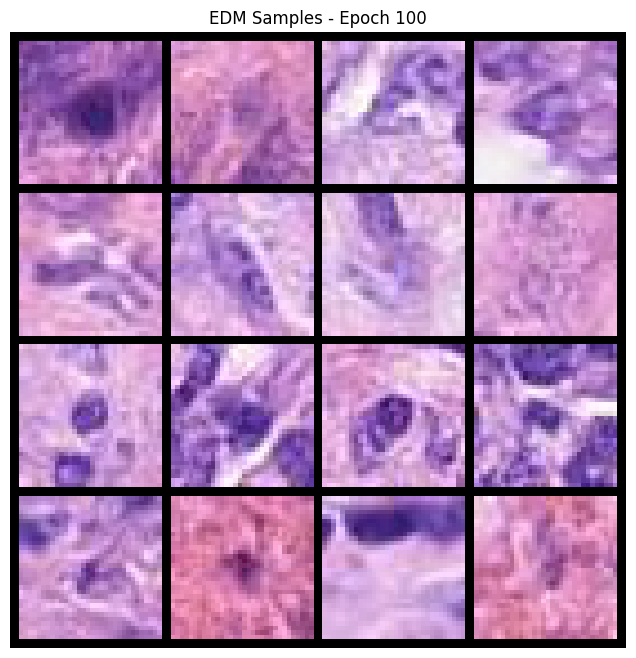

Training complete!


In [11]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99))

# Check for existing checkpoint
latest_checkpoint, start_epoch = find_latest_checkpoint(CHECKPOINT_DIR)
losses = []

if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    if 'losses' in checkpoint:
        losses = checkpoint['losses']
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

# Training loop
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    epoch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        # Compute EDM loss
        loss = edm_loss(model, x, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses,
        }, os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt'))
        print(f"Saved checkpoint at epoch {epoch+1}")

    # Generate samples every 5 epochs (using fast 50-step sampling)
    if (epoch + 1) % 5 == 0:
        samples = edm_sample(model, num_samples=16, num_steps=50)
        save_image(samples, os.path.join(SAMPLE_DIR, f'samples_epoch_{epoch+1}.png'), nrow=4)

        grid = make_grid(samples, nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f"EDM Samples - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()

        model.train()

print("Training complete!")

Saved final checkpoint


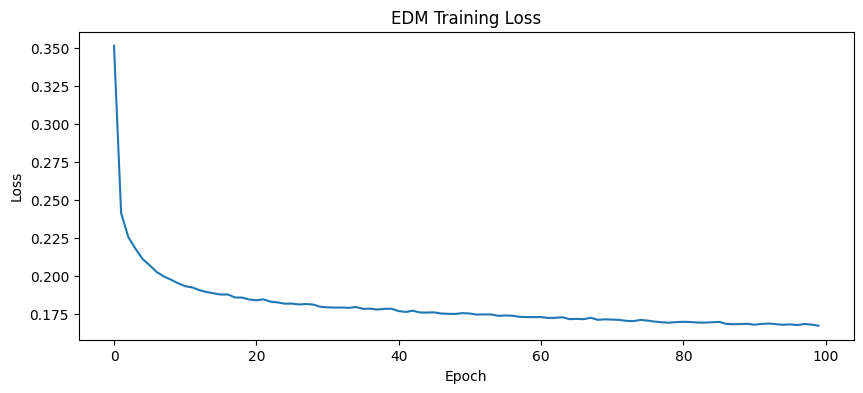

In [ ]:
# Save final model
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses[-1] if losses else 0,
    'losses': losses,
}, os.path.join(CHECKPOINT_DIR, 'checkpoint_final.pt'))
print("Saved final checkpoint")

# Plot training loss
if losses:
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('EDM Training Loss')
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'training_loss.png'))
    plt.show()

## Generate Samples by Class

In [ ]:
# Load checkpoint if needed
# checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'checkpoint_final.pt'), map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

Sampling (Heun): 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.63it/s]


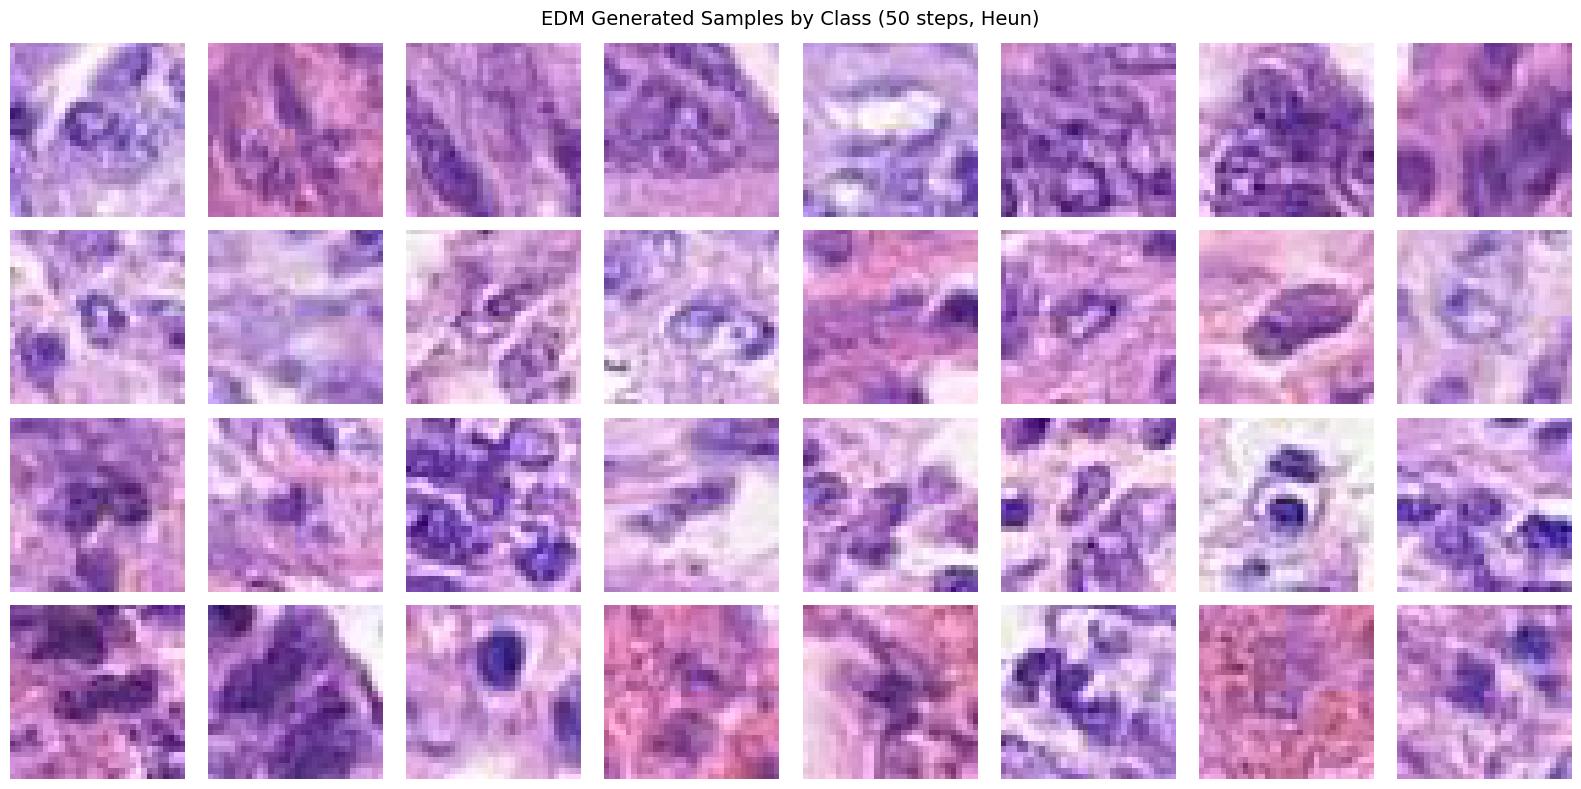

In [ ]:
# Generate samples for each class using Heun sampler (better quality)
model.eval()

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('EDM Generated Samples by Class (50 steps, Heun)', fontsize=14)

for class_idx, class_name in enumerate(CLASS_NAMES):
    labels = torch.full((8,), class_idx, device=device, dtype=torch.long)
    samples = edm_sample_heun(model, num_samples=8, class_labels=labels, num_steps=50)

    for i in range(8):
        axes[class_idx, i].imshow(samples[i].permute(1, 2, 0).cpu())
        axes[class_idx, i].axis('off')
    axes[class_idx, 0].set_ylabel(class_name, fontsize=12, rotation=0, labelpad=60)

plt.tight_layout()
plt.savefig(os.path.join(SAMPLE_DIR, 'edm_generated_by_class.png'), dpi=150)
plt.show()

## Compare Sampling Steps

Sampling (Heun): 100%|███████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.50it/s]


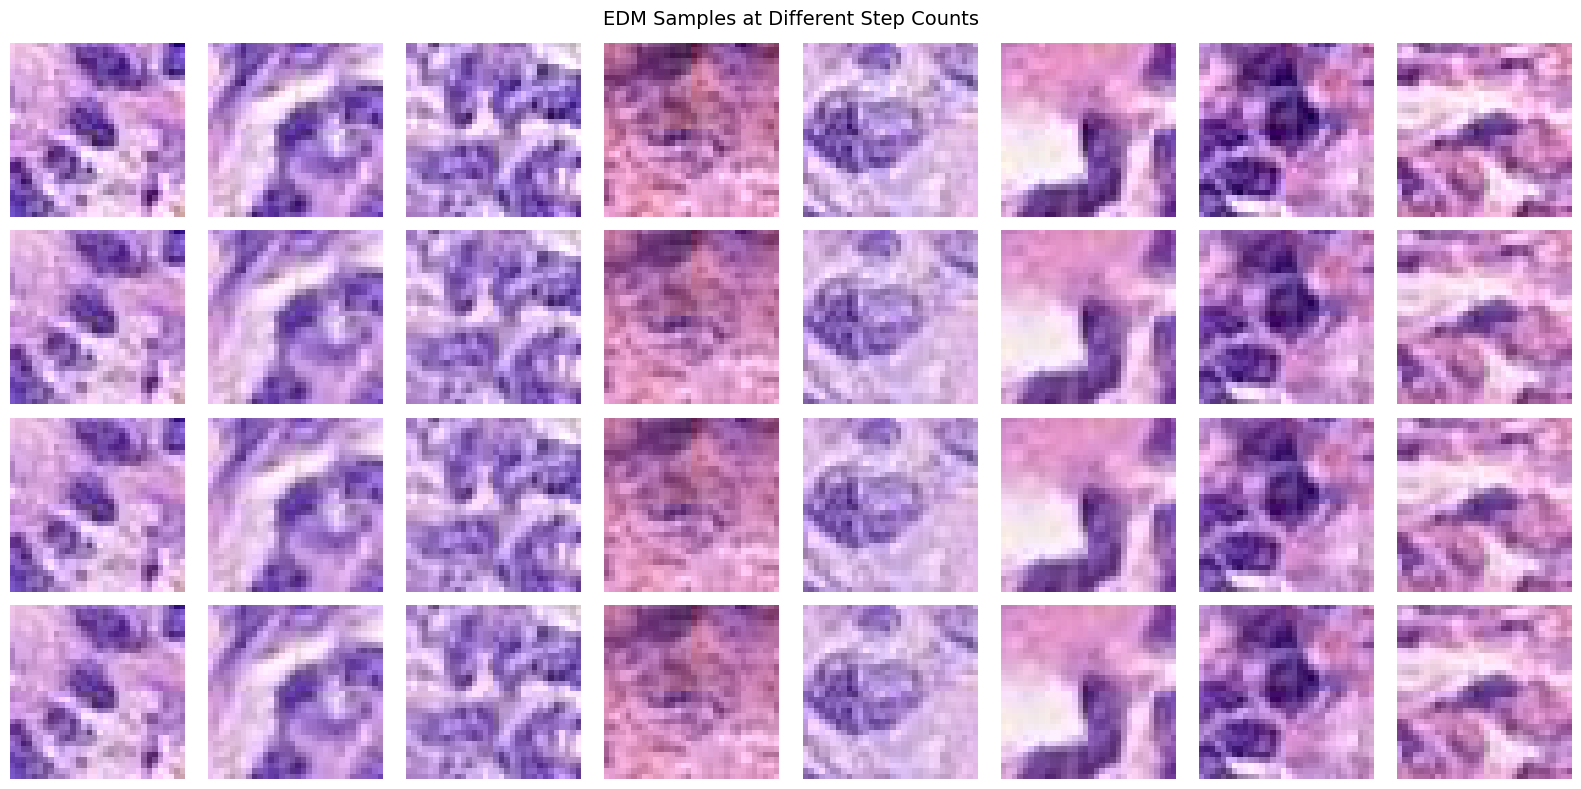

In [ ]:
# Compare quality at different sampling steps
model.eval()

step_counts = [10, 25, 50, 100]
fig, axes = plt.subplots(len(step_counts), 8, figsize=(16, 8))
fig.suptitle('EDM Samples at Different Step Counts', fontsize=14)

# Fix random seed for comparison
torch.manual_seed(42)
labels = torch.arange(4, device=device).repeat(2)

for row, steps in enumerate(step_counts):
    torch.manual_seed(42)  # Reset seed for fair comparison
    samples = edm_sample_heun(model, num_samples=8, class_labels=labels, num_steps=steps)

    for i in range(8):
        axes[row, i].imshow(samples[i].permute(1, 2, 0).cpu())
        axes[row, i].axis('off')
    axes[row, 0].set_ylabel(f'{steps} steps', fontsize=12, rotation=0, labelpad=50)

plt.tight_layout()
plt.savefig(os.path.join(SAMPLE_DIR, 'edm_step_comparison.png'), dpi=150)
plt.show()

## Generate Augmentation Data

In [ ]:
def generate_augmentation_data_edm(model, output_dir, samples_per_class, num_steps=50):
    """Generate synthetic images using EDM for data augmentation"""
    model.eval()

    for class_name, num_samples in samples_per_class.items():
        if num_samples == 0:
            continue

        class_idx = CLASS_TO_IDX[class_name]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        print(f"Generating {num_samples} samples for '{class_name}'...")

        batch_size = 64
        generated = 0

        while generated < num_samples:
            current_batch = min(batch_size, num_samples - generated)
            labels = torch.full((current_batch,), class_idx, device=device, dtype=torch.long)

            # Use Heun sampler for better quality
            samples = edm_sample_heun(model, num_samples=current_batch, class_labels=labels, num_steps=num_steps)

            for i, sample in enumerate(samples):
                img = (sample.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                img = Image.fromarray(img)
                img.save(os.path.join(class_dir, f'synthetic_{generated + i:05d}.png'))

            generated += current_batch
            print(f"  {generated}/{num_samples}")

        print(f"  Saved to {class_dir}")


# Uncomment to generate augmentation data
# augmentation_samples = {
#     'epithelial': 0,
#     'inflammatory': 750,
#     'fibroblast': 2000,
#     'others': 5400
# }
#
# generate_augmentation_data_edm(
#     model=model,
#     output_dir=os.path.join(SAMPLE_DIR, 'augmentation'),
#     samples_per_class=augmentation_samples,
#     num_steps=50
# )

## DDPM vs EDM Comparison Summary

| Aspect | DDPM | EDM |
|--------|------|-----|
| **Noise Schedule** | Discrete timesteps (0-999) | Continuous σ (log-normal) |
| **Training Objective** | Predict noise ε | Predict denoised image x |
| **Preconditioning** | None | c_skip, c_out, c_in, c_noise |
| **Sampling Steps** | 1000 (slow) | 35-50 (fast) |
| **Sampler** | Ancestral (stochastic) | Euler/Heun (deterministic) |
| **FID (CIFAR-10)** | ~3.2 | ~1.79 (SOTA) |